# <u>Chapter 6</u>: Teaching Machines to Translate

A serious impediment to spreading new information, ideas, and knowledge is the language barriers imposed by the different languages spoken worldwide. Despite the cultural richness brought to our global heritage, they can pose significant hurdles to efficient human communication. This exercice focuses on `machine translation` (MT), which aims to alleviate these barriers. MT is the process of automatically converting a piece of text from a source into a target language without human intervention. 

In [1]:
import sys
import subprocess
import pkg_resources

# Find out which packages are missing.
installed_packages = {dist.key for dist in pkg_resources.working_set}
required_packages = {'numpy', 'tensorflow', 'pandas', 'keras'}
missing_packages = required_packages - installed_packages

# If there are missing packages install them.
if missing_packages:
    print('Installing the following packages: ' + str(missing_packages))
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing_packages], stdout=subprocess.DEVNULL)

Now, download the datasets.

In [ ]:
import os

# Check if the data directory already exists.
if not os.path.exists("data"):
    # URL of the zip data file to download.
    url = "https://github.com/PacktPublishing/Machine-Learning-Techniques-for-Text/raw/main/chapter-06/data.zip"

    # If it doesn't exist, download the zip file.
    !wget {url}

    # Unzip the file into the "data" folder.
    !unzip -q "data.zip"

    !mkdir images

## Sequence-to-sequence learning

Many kinds of problems in machine learning involve transforming an input sequence into an output one. `Sequence-to-sequence` (seq2seq) learning has proven useful in applications that demand this transformation. Seq2seq, pronounced as `seek-to-seek`, learning falls under the category of neural MT, and unlike solutions based on RBMT and SMT, no domain knowledge of the languages involved is necessary. You can treat the translation problem as the association between input and output tokens of words or characters. Moreover, the translation is end-to-end, which means that one model is required instead of many.

To create the seq2seq model, we will utilize an English-to-French bilingual corpus consisting of ~200K source-target pairs. Due to resource limitations, we will only keep _8000_ of those pairs to build the model. The code that follows shows the specific steps.

In [2]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)

import pandas as pd
import re

# Read the first 8K pairs in the dataset.
# Reduce the nrows parameter if there is a memory allocation problem.
data = pd.read_table('./data/fra.txt',  usecols=range(2), names=['source', 'target'], nrows=8000)

# Replace no-break and thin spaces in the target sentences.
data.target = data.target.apply(lambda x: re.sub(u'\xa0|\u202f|\u2009', u' ', x))
data.sample(5, random_state=123)

,source,target
5676,Tom is loyal.,Tom est fidèle.
617,I'm game.,J'en suis.
415,Back off!,Cassez-vous.
7687,Life is crazy.,La vie est dingue.
6708,I caused this.,J'ai causé ceci.


Next, the _&lt;sos&gt;_ and _&lt;eos&gt;_ tokens are added to the target sentences at the beginning and the end, respectively.

In [3]:
# Add two special tokens in the target sentences (start_of_stream/end_of_stream).
data['target'] = '<sos> ' + data['target'] + ' <eos>'
data.target[100]

'<sos> Je payai. <eos>'

Let’s extract the vocabulary size of the sentences in the source and target corpora.

In [4]:
# Extract the vocabulary of the source/target sentences.
src_voc = sorted(list(data['source'].str.split(' ', expand=True).stack().unique()))
trg_voc = sorted(list(data['target'].str.split(' ', expand=True).stack().unique()))

# Get the vocabulary size for the source/target sentences.
# Increase by one for the padding token.
src_voc_size = len(src_voc) + 1
trg_voc_size = len(trg_voc) + 1

print("Vocabulary size of the source sentences:", src_voc_size)
print("Vocabulary size of the target sentences:", trg_voc_size)

Vocabulary size of the source sentences: 2504
Vocabulary size of the target sentences: 4818


Next, we must obtain the maximum length of the sentences in each case.

In [5]:
# Extract the maximum sentence length in the source/target sentences.
max_src_len = max([(len(s.split(' '))) for s in data['source']])
max_trg_len = max([(len(s.split(' '))) for s in data['target']])

print("Maximum length of the source sentences:", max_src_len)
print("Maximum length of the target sentences:", max_trg_len)

Maximum length of the source sentences: 5
Maximum length of the target sentences: 12


The previous statistics are essential as they let us configure the dimensions of the different units of the model.

We need a dictionary to map numerical values to the output words for the decoder.

In [6]:
# Create the word-to-index dictionary for the source/target tokens.
# Zero index reserved for the padding token.
src_word2idx = dict([(word, idx+1) for idx, word in enumerate(src_voc)])
trg_word2idx = dict([(word, idx+1) for idx, word in enumerate(trg_voc)])

print(trg_word2idx['Non'])

675


And here is the code for the index-to-word dictionary.

In [7]:
# Create the index-to-word dictionary for the source/target tokens.
src_idx2word = dict([(idx, word) for word, idx in src_word2idx.items()])
trg_idx2word = dict([(idx, word) for word, idx in trg_word2idx.items()])

print(trg_idx2word[675])

Non


Let’s examine the steps for creating the model by specifying the format of the input and output data.

In [8]:
import numpy as np

# The input/output data of the model.
enc_input_data = np.zeros((len(data['source']), max_src_len), dtype='float32')
dec_input_data = np.zeros((len(data['source']), max_trg_len), dtype='float32')
dec_output_data = np.zeros((len(data['source']), max_trg_len, trg_voc_size), dtype='float32')

Observe how _max_src_len_ and _max_trg_len_ determine the size of the created arrays. Next, we iterate over the whole dataset, transforming words into numerical values for the encoder’s and the decoder’s input while creating the one-hot array for the decoder’s output.

In [9]:
# Iterate over the whole dataset.
for i, (src_sentence, trg_sentence) in enumerate(zip(data['source'], data['target'])):
    
    # Create the input for the encoder.
    for j, word in enumerate(src_sentence.split()):
        enc_input_data[i, j] = src_word2idx[word]
 
    # Create the input/output for the decoder.
    for j, word in enumerate(trg_sentence.split()):
        # Skip the '<eos>' word in the decoder input.
        if j < len(trg_sentence.split())-1:
            dec_input_data[i, j] = trg_word2idx[word]
        # Skip the '<sos>' word in the decoder output.
        if j > 0:
            dec_output_data[i, j-1, trg_word2idx[word]] = 1.0

Now, we can set up the architecture of the training model, which is a graph of layers.

In [10]:
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

# Create the input layers for the encoder/decoder.
enc_input = Input(shape=(None,), dtype='float32',)
dec_input = Input(shape=(None,), dtype='float32',)

# Create the embedding layers for the encoder/decoder.
embed_layer = Embedding(src_voc_size, 256, mask_zero=True)
enc_embed = embed_layer(enc_input)
embed_layer = Embedding(trg_voc_size, 256, mask_zero=True)
dec_embed = embed_layer(dec_input)

# Create the LSTM layers for the encoder/decoder.
enc_LSTM = LSTM(256, return_state=True)
_, state_h, state_c = enc_LSTM(enc_embed)
dec_LSTM = LSTM(256, return_state=True, return_sequences=True)
# The initial states of the decoder are the output from the encoder.
dec_output, _, _ = dec_LSTM(dec_embed, initial_state=[state_h, state_c])

# Create the output layer for the decoder.
dec_dense = Dense(trg_voc_size, activation='softmax')
dec_output = dec_dense(dec_output)

Now that all the pieces are in place, we can start constructing and training the complete encoder/decoder model.

### Training the model

The training model takes two inputs (_enc_input and dec_input_) and emits one output (_dec_output_).

In [11]:
# Create and compile the model.
model = Model([enc_input, dec_input], dec_output)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()
model_params = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
print("Number of trainable parameters:", model_params)

Number of trainable parameters: 4163282


As a measure of the complexity of the model, we print the number of its trainable parameters. In total, _4163282_ parameters must be estimated. 

In [12]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 256)    641024      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    1233408     ['input_2[0][0]']                
                                                                                              

Now, let’s visualize the different layers of the training model that we created.

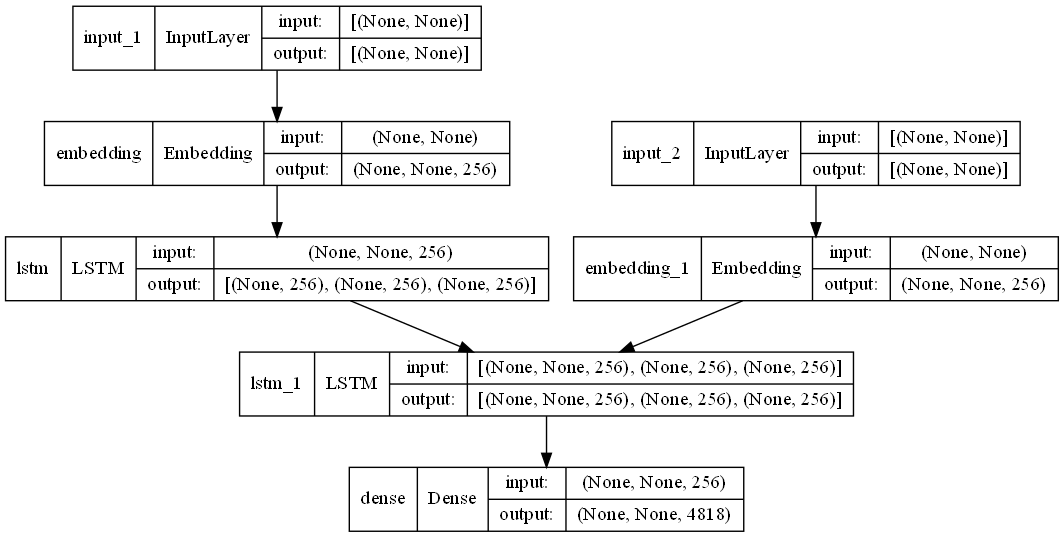

In [13]:
from tensorflow.keras.utils import plot_model

# Plot the model.
plot_model(model, to_file='./images/model_plot.png', show_shapes=True, show_layer_names=True, dpi=100)

After the whole architecture is in place, we start the training process by fitting the data to the model.



In [14]:
# Fit the data to the model.
model.fit([enc_input_data, dec_input_data], dec_output_data,
            batch_size=128, epochs=100, validation_split=0.2, shuffle=False)

Epoch 1/100
50/50 [==============================] - 19s 170ms/step - loss: 2.0813 - accuracy: 0.2364 - val_loss: 2.1181 - val_accuracy: 0.2200
Epoch 2/100
50/50 [==============================] - 6s 111ms/step - loss: 1.7052 - accuracy: 0.2732 - val_loss: 2.0120 - val_accuracy: 0.2877
Epoch 3/100
50/50 [==============================] - 6s 110ms/step - loss: 1.5774 - accuracy: 0.2883 - val_loss: 1.9714 - val_accuracy: 0.3064
Epoch 4/100
50/50 [==============================] - 7s 134ms/step - loss: 1.4770 - accuracy: 0.3019 - val_loss: 1.9326 - val_accuracy: 0.3075
Epoch 5/100
50/50 [==============================] - 6s 128ms/step - loss: 1.4016 - accuracy: 0.3198 - val_loss: 1.9060 - val_accuracy: 0.3115
Epoch 6/100
50/50 [==============================] - 6s 129ms/step - loss: 1.3449 - accuracy: 0.3479 - val_loss: 1.9046 - val_accuracy: 0.3006
Epoch 7/100
50/50 [==============================] - 7s 135ms/step - loss: 1.2949 - accuracy: 0.3722 - val_loss: 1.8852 - val_accuracy: 0.328

According to the validation_split parameter, 80% of the bilingual pairs are used for training, while the other 20% are used for testing. After _100_ epochs, we achieve an accuracy of around _88%_. 

### Testing the model

Before using the trained model for inference, we must change its architecture so that the output of each decoder timestep becomes an input to the subsequent one. The encoder remains unchanged. 

In [15]:
# Model to encode the input.
enc_model = Model(enc_input, [state_h, state_c])

# The hidden and cell states of the decoder at each step.
dec_state_in_h = Input(shape=(256,))
dec_state_in_c = Input(shape=(256,))

# Set the embedding layer.
dec_embed_2 = embed_layer(dec_input)

# Set the LSTM layer.
dec_output_2, dec_state_out_h, dec_state_out_c = dec_LSTM(dec_embed_2, initial_state=[dec_state_in_h, dec_state_in_c])

# Set the output layer for the decoder.
dec_output_2 = dec_dense(dec_output_2)

# Create the decoder model.
decoder_model = Model([dec_input] + [dec_state_in_h, dec_state_in_c],
                        [dec_output_2] + [dec_state_out_h, dec_state_out_c])

Next, we must visualize the architecture of the altered decoder.

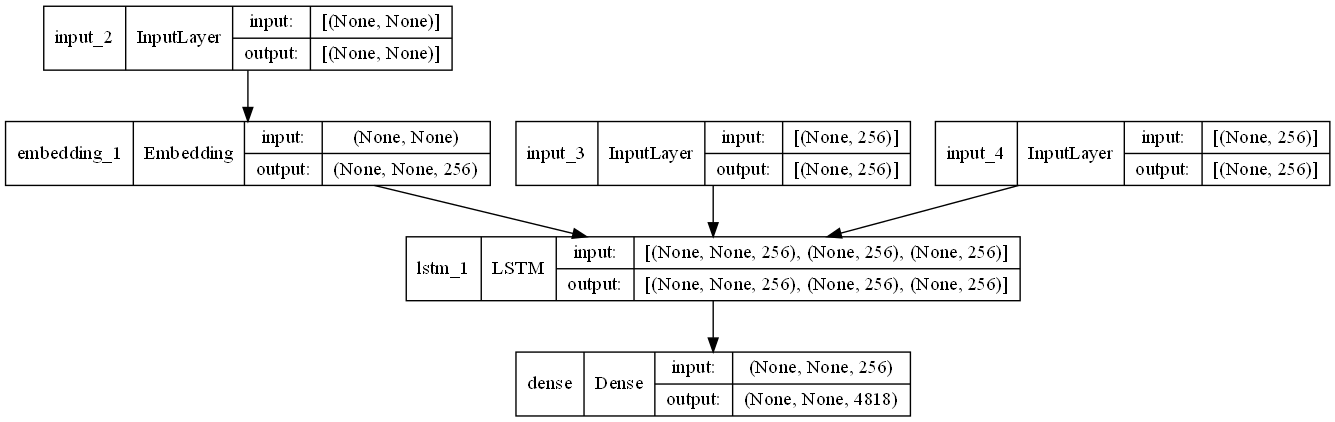

In [16]:
# Plot the model.
plot_model(decoder_model, to_file='./images/inference_model_plot.png', show_shapes=True, show_layer_names=True, dpi=100)

Now, it’s time to extract a translation for a given sentence. Here, we must include the necessary steps in the _getTranslation_ method and present them in detail. First, the method receives the index part of an example in the dataset.

In [17]:
# Translate an input sentence.
def getTranslation(index):

    translation = word = ''

    # Choose randomly a sequence from the data set.
    #i = np.random.choice(len(data['source']))

    # Choose a sequence from the data set.
    source_seq = enc_input_data[index:index+1]

    # Get the initial input states for the decoder.
    states_h_c = enc_model.predict(source_seq)

    # The first input token to the decoder is start_of_stream.
    token = np.zeros((1,1))
    token[0, 0] = trg_word2idx['<sos>']

    # Start the decoding process.
    while (word != '<eos>' and len(translation) <= 100):

        # Predict the next token and states.
        output, state_h, state_c = decoder_model.predict([token] + states_h_c)
        
        # Store the emitted token and the states for the next iteration.
        idx = np.argmax(output[0, -1, :])
        token[0, 0] = idx
        states_h_c = [state_h, state_c]

        # Extract the emitted word.
        word = trg_idx2word[idx]
        translation += ' ' + word

    return translation

It’s now time to call the method.

In [18]:
print("Input sentence:", data['source'][1308])
print("Reference translation:", data['target'][1308].replace("<sos>","").replace("<eos>",""))
print("Hypothesis:", getTranslation(1308)[:-6])

Input sentence: Seriously?
Reference translation:  C'est vrai ? 
Hypothesis:  Vraiment ?


## Translation performance

An appropriate metric for evaluating the quality of MT systems is the `BiLingual Evaluation Understudy` (BLEU) score. Using BLEU, we compare the generated prediction to a reference sentence by counting matching n-grams in both cases.

In [19]:
from nltk.translate.bleu_score import sentence_bleu

hypothesis = getTranslation(1006)[:-6].split()
reference = data['target'][1006].replace("<sos>","").replace("<eos>","").split()

# Calculate the BLEU score.
bleu = sentence_bleu([reference], hypothesis, weights=(1, 1, 1))

print("Input sentence:", data['source'][1006])
print("Reference translation:", reference)
print("Hypothesis:", hypothesis)
print("BLEU score:", bleu)

Input sentence: I relaxed.
Reference translation: ['Je', 'me', 'suis', 'détendue.']
Hypothesis: ['Je', 'me', 'suis', 'détendu.']
BLEU score: 0.25


## What we have learned …

| | |
| --- | --- |
| **ML algorithms & models**<ul><li>Recurrent Neural Networks</li></ul> |  **Performance metrics**<ul><li>BLEU score</li></ul> |
| | |